<a id='top3'></a>
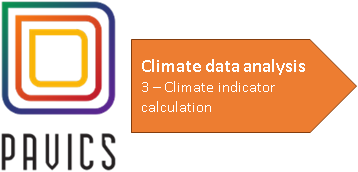


This third tutorial will demonstate PAVICS tools for calculating climate indicators, accessing Ouranos' <a href="https://www.nature.com/articles/s41597-023-02855-z" target="_blank">**ESPO-G6-R2 v1.0**</a> ensemble.  PAVICS incorporates the <a href="https://xclim.readthedocs.io/en/stable/" target="_blank">xclim</a> library which essentially has two layers for the calculation of indicators. The first `xclim.indices` is a core layer and contains the various algorithms and calculation logic, as well as any potential unit conversions.  A second layer consists of `xclim.core.indicator.Indicator` instances that essentially perform the same computations found in `xclim.indices`, but also run a number of health checks on input data and assign attributes to the output arrays. Indicators are split into realms (`atmos`, `land`, `seaIce`), according to the variables they operate on. 

This tutorial uses the `xclim.atmos` module outlining steps for:

* [Climate indicator calculation](#climcalc)
* [Missing data options](#missing)
* [French language metadata fields](#french)

Advanced topics:

* [Simple multiprocessing of an ensemble](#multiproc)

We re-use part of the data-access and subset tutorials to select a dataset from cb-oura-1.0 datasets from the PAVICS THREDDS server.

<div class="alert alert-info">
To conserve any modifications to tutorial notebooks in the PAVICS JupyterLab they need to be copied into your <a href=#workspace>writable-workspace</a> directory.    
</div>
    

<xarray.Dataset> Size: 350MB
Dimensions:       (rlat: 22, rlon: 24, time: 55115)
Coordinates:
  * rlat          (rlat) float32 88B -7.29 -7.2 -7.11 -7.02 ... -5.58 -5.49 -5.4
  * rlon          (rlon) float32 96B 376.4 376.4 376.5 ... 378.2 378.3 378.4
    rotated_pole  float32 4B ...
  * time          (time) object 441kB 1950-01-01 00:00:00 ... 2100-12-31 00:0...
    lat           (rlat, rlon) float32 2kB dask.array<chunksize=(13, 16), meta=np.ndarray>
    lon           (rlat, rlon) float32 2kB dask.array<chunksize=(13, 16), meta=np.ndarray>
Data variables:
    tasmin        (time, rlat, rlon) float32 116MB dask.array<chunksize=(1460, 13, 16), meta=np.ndarray>
    tasmax        (time, rlat, rlon) float32 116MB dask.array<chunksize=(1460, 13, 16), meta=np.ndarray>
    pr            (time, rlat, rlon) float32 116MB dask.array<chunksize=(1460, 13, 16), meta=np.ndarray>
    lakeFrac      (rlat, rlon) float32 2kB dask.array<chunksize=(13, 16), meta=np.ndarray>
    sftlf         (rlat, rlon) float32 2kB dask.array<chunksize=(13, 16), meta=np.ndarray>
    sftof         (rlat, rlon) float32 2kB dask.array<chunksize=(13, 16), meta=np.ndarray>
    crs           int64 8B 1
Attributes: (12/81)
    Conventions:                     CF-1.7 CMIP-6.2
    Notes:                           Regridded on the grid of RDRS v2.1, then...
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           109573.0
    ...                              ...
    license_type:                    permissive
    terms_of_use:                    In addition to the provided licence, the...
    attribution:                     Use of this dataset should be acknowledg...
    modeling_realm:                  atmos
    source_institution:              NUIST
    crs:                             EPSG:4326

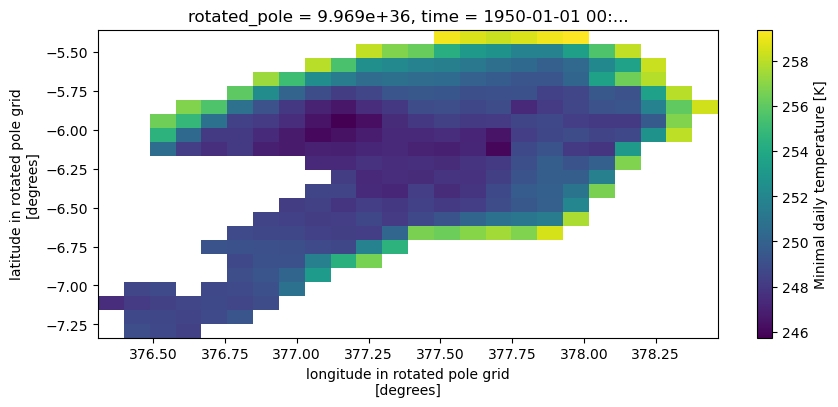

In [1]:
import os

os.environ["USE_PYGEOS"] = "0"  # force use Shapely with GeoPandas
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import xarray as xr
from clisops.core import subset
from dask.diagnostics import ProgressBar
from siphon.catalog import TDSCatalog
from xclim import atmos

warnings.simplefilter("ignore")
# TODO change address
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip6/ouranos/ESPO-G/ESPO-G6-R2v1.0.0/catalog.xml"  # TEST_USE_PROD_DATA

# Create Catalog
cat = TDSCatalog(url)

# Subset over the Gaspé peninsula in eastern Quebec
gaspe = gpd.GeoDataFrame.from_file(
    "/notebook_dir/pavics-homepage/tutorial_data/gaspesie_mrc.geojson"
)
ds = subset.subset_shape(
    xr.open_dataset(
        cat.datasets[0].access_urls["OPENDAP"],
        chunks=dict(time=365 * 4, rlon=50, rlat=50),
    ),
    shape=gpd.GeoDataFrame(geometry=gaspe.buffer(0.05)),
)

# What we see here is only a representation of the full content, the entire data set hasn't been loaded.
display(ds)

# plot of single day tasmin
a = ds.tasmin.isel(time=0).plot(figsize=(10, 4))

<a id='climcalc'></a>
## Climate indicator calculation
The `atmos` module allows us to easily calculate a large number of climate indicators. For example we can determine the projected the number of days with maximum temperature above a threshold for our test dataset using the `atmos.tx_days_above`.  The vast majority of `xclim.atmos` calculations employ a resample frequency parameter `freq` trivializing the calculation of yearly (`'YS'`), monthly (`'MS'`), seasonal (`'QS-DEC'`) or other frequencies following pandas <a href="https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases" target="_blank">resampling offsets.</a>


*[return to top of page](#top1)*

calculating yearly output using freq="YS"
[########################################] | 100% Completed | 10.10 ss
[########################################] | 100% Completed | 2.32 sms


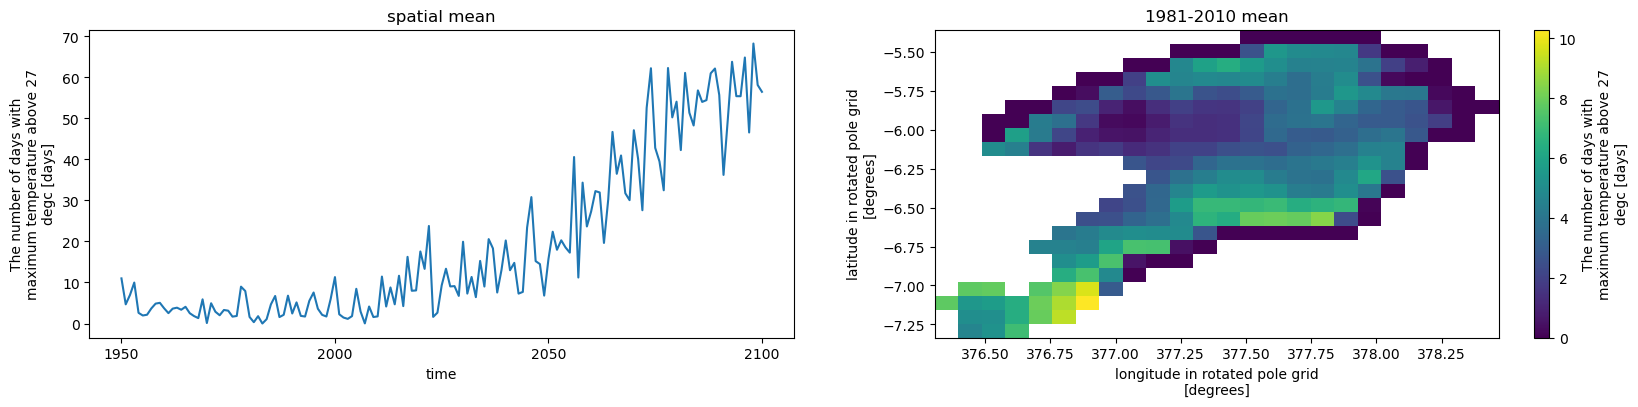

In [2]:
# NBVAL_IGNORE_OUTPUT

freq = "YS"
print(f'calculating yearly output using freq="{freq}"')
with ProgressBar():
    out = atmos.tx_days_above(
        tasmax=ds.tasmax, thresh="27 degC", freq=freq
    )  # Yearly frequency

    # Average over spatial domain and plot time-series
    fig1 = plt.figure(figsize=(20, 4))
    plt.subplot(1, 2, 1)
    out.mean(dim=["rlon", "rlat"], keep_attrs=True).plot()
    plt.title("spatial mean")

    # Calculate a 30 year climatology and plot a map
    plt.subplot(1, 2, 2)
    subset.subset_time(out, start_date="1981", end_date="2010").mean(
        dim="time", keep_attrs=True
    ).plot()
    plt.title("1981-2010 mean")
    display()

___
<a id='missing'></a>
### Missing data options
Some data sets require consideration of how best to deal with possible missing data in the input time-series. For example, The World Meteorological Organisation recommends that where monthly means are computed from daily values it should be considered missing if either of these two criteria are met:  observations are missing for 11 or more days during the month; observations are missing for a period of 5 or more consecutive days during the month.  Stricter criteria are sometimes used in practice, with a tolerance of 5 missing values or 3 consecutive missing values, or in other cases one may simply wish to use a simple percent threshold demonstrated below.

The `xclim.set_options` can be used to choose from a number of <a href="https://xclim.readthedocs.io/en/stable/checks.html#missing-values-identification" target="_blank">missing data options</a>.


*[return to top of page](#top1)*

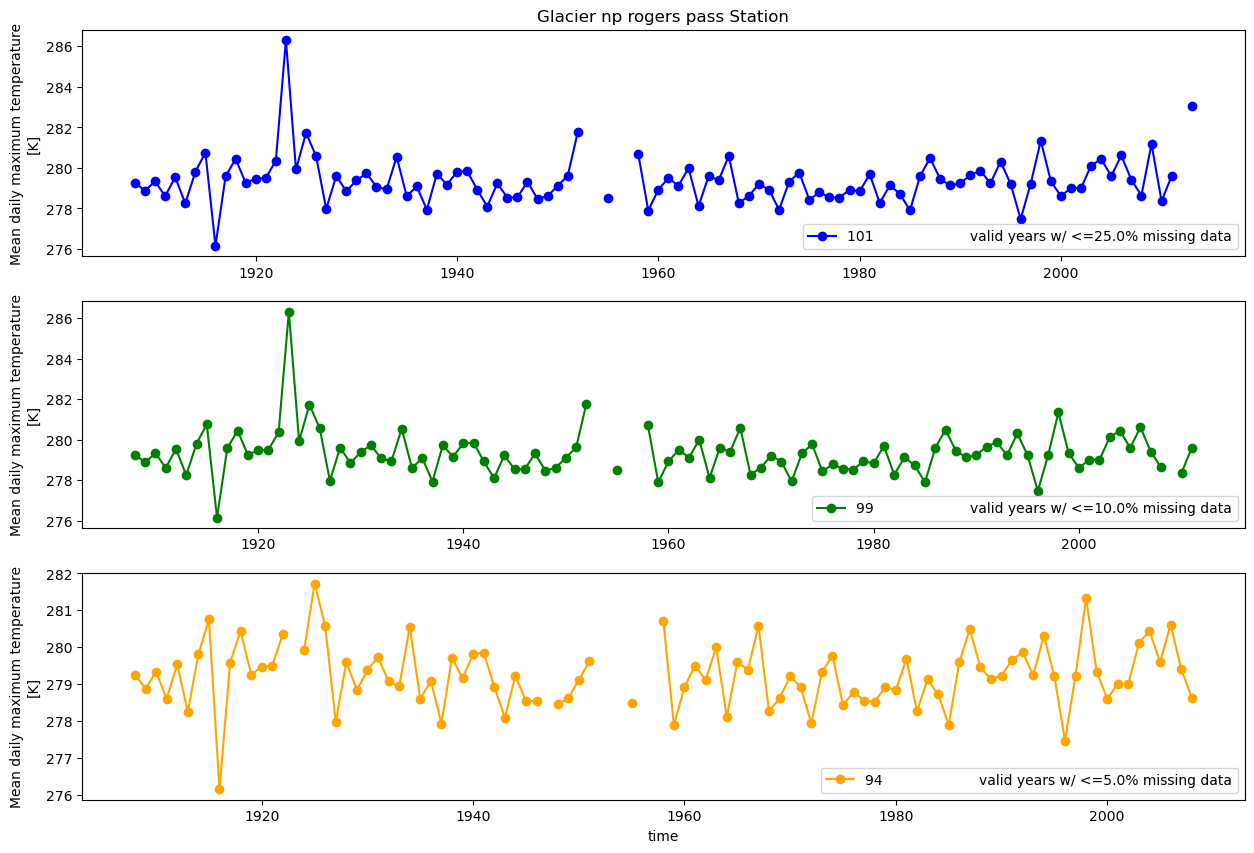

In [3]:
import xclim

# Access some station data
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml"
ds_stat = xr.open_dataset(url, chunks=dict(station=1))
istat = 115
# Compare use of differernt percent tolerance levels  (tolerance == 0.1)
plt.figure(figsize=(15, 10))
color = ["blue", "green", "orange"]

for i, tol in enumerate([0.25, 0.1, 0.05]):
    plt.subplot(3, 1, i + 1)
    with xclim.set_options(
        check_missing="pct", missing_options={"pct": {"tolerance": tol}}
    ):
        # compute yearly max tasmax
        tx_mean = xclim.atmos.tx_mean(
            tasmax=ds_stat.isel(station=istat).tasmax, freq="YS"
        )

        tx_mean.plot(
            marker="o",
            color=color[i],
            label=f"{len(tx_mean.dropna('time').values)} \
                     valid years w/ <={tol*100}% missing data",
        )
        plt.title("")
        plt.xlabel("")
        if i == 0:
            name = str(ds_stat.isel(station=istat).station_name.values)
            plt.title(f"{name.capitalize().replace('_',' ')} Station")

        elif i == 2:
            plt.xlabel("time")

        plt.legend(loc="lower right")

<a id='french'></a>
### Adding french language metadata fields

Climate indicator output can be customized to include additional translated metadata fields. French translations are supported directly while others can be user configured. By setting french language <a href="https://xclim.readthedocs.io/en/stable/internationalization.html#" target="_blank">internationalization</a>  options via `xclim.set_options` we note the additional `description_fr` and `longname_fr` attributes. 

*[return to top of page](#top1)*

In [4]:
# NBVAL_IGNORE_OUTPUT

with xclim.set_options(metadata_locales=["fr"]):
    out_fr = atmos.tx_days_above(tasmax=ds.tasmax, thresh="27 degC", freq="YS")
out_fr

<xarray.DataArray 'tx_days_above' (time: 151, rlat: 22, rlon: 24)> Size: 638kB
dask.array<where, shape=(151, 22, 24), dtype=float64, chunksize=(4, 13, 16), chunktype=numpy.ndarray>
Coordinates:
  * rlat          (rlat) float32 88B -7.29 -7.2 -7.11 -7.02 ... -5.58 -5.49 -5.4
  * rlon          (rlon) float32 96B 376.4 376.4 376.5 ... 378.2 378.3 378.4
    rotated_pole  float32 4B ...
    lat           (rlat, rlon) float32 2kB dask.array<chunksize=(13, 16), meta=np.ndarray>
    lon           (rlat, rlon) float32 2kB dask.array<chunksize=(13, 16), meta=np.ndarray>
  * time          (time) object 1kB 1950-01-01 00:00:00 ... 2100-01-01 00:00:00
Attributes:
    units:           days
    cell_methods:    time: maximum within days time: sum over days
    history:         [2024-11-05 20:09:30] Data compressed with BitRound by k...
    standard_name:   number_of_days_with_air_temperature_above_threshold
    long_name:       The number of days with maximum temperature above 27 degc
    description:     Annual number of days where daily maximum temperature ex...
    long_name_fr:    Nombre de jours ayant une température maximale quotidien...
    description_fr:  Nombre annuel de jours où la température maximale quotid...

___

### Advanced Topics
<a id='multiproc'></a>
#### Parallel processing climate indicator calculations

xclim uses `xarray` and its built-in support of `Dask` parallelization for most of its operations allowing for simple configuration of climate indicator calculation employing <a href="http://xarray.pydata.org/en/stable/dask.html" target="_blank">parallel computing</a>. Here we show a simple workflow to calculate climate indicators using Ouranos' **ESPO-G6-R2** bias-adjusted simulations.   From a user standpoint simply specifying the `chunks` argument when opening the data via `xarray.open_dataset` will autmomatically result in dask being employed.  In this case, the calculations are additionally computed in parrallel via a `dask.distributed` client of worker processes instead of the default scheduler.


#### User input section
Many PAVICS users may wish to simply calculate a list of custom defined climate indicators over their own region of interest.  The following code section shows an example showing how to:
* Select the dataset(s) to be used (in this case ESPO-G6-R2 v1.0 thredds catalogue url)
* Use a subset region of interest (in this case a polygon over Gaspésie)
* Select a start and end date on which to perform the calculations
* Employ an `xclim` <a href="https://xclim.readthedocs.io/en/stable/notebooks/extendxclim.html#Virtual-modules" target="_blank">virtual module</a> defining the calculations of interest via a [YML](tutorial_data/xclim_virtmodule.yml) file

*[return to top of page](#top1)*


In [5]:
from pathlib import Path

from dask import compute
from dask.distributed import Client
from IPython.display import clear_output, display
from xclim.core.indicator import build_indicator_module_from_yaml

# ESPO-G6-R2 v1.0 catalogue
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip6/ouranos/ESPO-G/ESPO-G6-R2v1.0.0/catalog.xml"  # TEST_USE_PROD_DATA

# Model list for transient climate response in IPCC "likely" range
tcr_likely_models = [
    "BCC-CSM2-MR",
    "FGOALS-g3",
    "CMCC-ESM2",
    "CNRM-ESM2-1",
    "ACCESS-CM2",
    "ACCESS-ESM1-5",
    "MPI-ESM1-2-HR",
    "INM-CM5-0",
    "MIROC6",
    "MPI-ESM1-2-LR",
    "MRI-ESM2-0",
    "NorESM2-LM",
    "KACE-1-0-G",
    "GFDL-ESM4",
    "MIROC-ES2L",
]


def _filter_tcr_likely(files):
    return [d for d in files if any([h in d.name for h in tcr_likely_models])]


# create a simple search sub-function


def get_ncfilelist(scen=None, url=None, tcr_likely=False):
    cat = TDSCatalog(url)
    ncfiles = [cat.datasets[c] for c in cat.datasets if scen in c]
    if tcr_likely:
        expected = len(tcr_likely_models)
        ncfiles = _filter_tcr_likely(ncfiles)
        if len(ncfiles) == expected:
            display(f"Successfully found {expected} datasets for {scen}")
            return ncfiles
        else:
            raise ValueError(
                f"Expected number of datasets for {scen} is {expected} : found {len(ncfiles)}"
            )


# specify output folder for netcdf files
output = "/notebook_dir/writable-workspace/tmp/tutorial3/output"

# Create Catalog
cat = TDSCatalog(url)

datasets = {}
for scen in ["ssp245", "ssp370"]:
    datasets[scen] = get_ncfilelist(scen=scen, url=url, tcr_likely=True)

'Successfully found 15 datasets for ssp245'

'Successfully found 15 datasets for ssp370'

In [6]:
# We will subset over the Gaspé peninsula in eastern Quebec
gaspe = gpd.GeoDataFrame.from_file(
    "/notebook_dir/pavics-homepage/tutorial_data/gaspesie_mrc.geojson"
)

# buffer the region slightly (.05 degrees) to include slightly more gridcells than necessary
gaspe = gpd.GeoDataFrame(geometry=gaspe.buffer(0.05))

# calculate on data using start year - if `start_date=None` calculation starts on the intitial timestep
start_date = "1981"

# define an end_date - if `end_date=None` calculation will use the last timestep as an end_date
end_date = None

# import the example YML module defining the four indicators to calculate
indmod = build_indicator_module_from_yaml(
    Path("tutorial_data/xclim_virtmodule"), mode="raise"
)

for name, ind in indmod.iter_indicators():
    print(name, ":", ind)

tx_days_above_27_annual : <xclim.indicators.pavics-demo.TX_DAYS_ABOVE_27_ANNUAL object at 0x7f09fa07b690>
tx_days_above_27_seasonal : <xclim.indicators.pavics-demo.TX_DAYS_ABOVE_27_SEASONAL object at 0x7f09fa07a9d0>
tx_mean_annual : <xclim.indicators.pavics-demo.TX_MEAN_ANNUAL object at 0x7f09fa07ad10>
tx_mean_seasonal : <xclim.indicators.pavics-demo.TX_MEAN_SEASONAL object at 0x7f0994707d10>


#### Parallel processing section
The following section of code will execute the calculations prepared above. In many cases the following code can be used as is (or with only slight modifications). It will iteratively prepare a series `dask.delayed` computations on the input datasets found within the THREDDS catalog url (in this case we prepare `dask.delayed` tasks to output one netcdf file per simulation per climate indicator calculation). Then, employing a dask distributed `Client`, simulataneously execute all calculations in parralel. Climate indicator calculation output netcdf files are written into an `output` subfolder.

<div class="alert alert-info"><strong>Info!</strong> Despite increased performance via parallel processing executing this portion of the tutorial will likely take some time to finish all computations.
</div>

In [7]:
# NBVAL_SKIP

# Parallel computing part...
dask_kwargs = dict(
    n_workers=6,
    threads_per_worker=6,
    memory_limit="4GB",
    local_directory="/notebook_dir/writable-workspace/tmp",
)

xr_kwargs = dict(decode_timedelta=False, chunks=dict(time=(365 * 4), rlon=50, rlat=50))
with Client(**dask_kwargs) as c:
    clear_output()
    for ssp, ds_list in datasets.items():
        # print(ssp, datasets)
        for dd in ds_list:
            ds = xr.open_dataset(dd.access_urls["OPENDAP"], **xr_kwargs)
            ds = subset.subset_shape(ds, shape=gaspe).sel(
                time=slice(start_date, end_date)
            )
            outfile_root = "_".join(dd.name.split("_")[1:-1])
            print(outfile_root)
            jobs = []
            for name, ind in indmod.iter_indicators():
                clear_output(wait=True)
                print(f"preparing calculation {name} for {outfile_root}... ")
                dsout = xr.Dataset(attrs=ds.attrs)
                out = ind(ds=ds)
                outfile = Path(output).joinpath(
                    f"{name}_{outfile_root}_{out.time[0].dt.strftime('%Y').values}-{out.time[-1].dt.strftime('%Y').values}.nc"
                )
                print(outfile)
                dsout[out.name] = out
                outfile.parent.mkdir(exist_ok=True, parents=True)
                display(c)
                dsout.to_netcdf(outfile, mode="w")

    c.restart()
clear_output()
print("Finished")

Finished


___
### Notes

<a id='workspace'></a>

<div class="alert alert-info"><strong>Info! writeable-workspace location.</strong> To conserve any modifications and to avoid permission errors for notebooks which write output to disk it is necessary to copy tutorial notebooks from the "pavics-homepage" folder to a location within your "writeable-workspace"
</div>

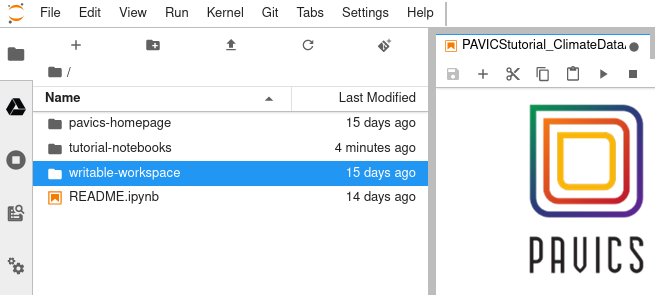

*[return to top of page](#top3)*